<a href="https://colab.research.google.com/github/SupermarketAutomationAI/bounding_box/blob/main/Fast_Fruit.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Import all Libraries needed for this Notebook

In [1]:
import os
import json
import math
import shutil
from glob import glob

import torch
import torch.nn as nn
import torch.optim as optim 
import torch.nn.functional as F
import torchvision.models
from torchvision import datasets, transforms
import numpy as np
import matplotlib.pyplot as plt
import time
import itertools
from sklearn.metrics import confusion_matrix

#from models import *
#from utils import *
import sys, datetime, random
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from torch.autograd import Variable
import matplotlib.patches as patches
from PIL import Image

import tensorflow as tf
import torchvision.transforms as T
import cv2

# Data Loading, Splitting, and Processing

This Jupyter notebook section contains the data processing for data processing for the sanity checks. The format of this version is as follows:

/V3_combined_all_DS
```
/train
  Banana
  Red_Delicious_Apple
  Orange
  .
  .
/val
  Banana
  Red_Delicious_Apple
  Orange
  .
  .
/test
  Banana
  Red_Delicious_Apple
  Orange
  .
  .
```
Where each of the above subdirectories in train, val, and test are their own class. In this version, there is one class for each type of fruit, and there are 19 fruit classes.

Classes: 

['Bananas', 'Carambola', 'Fuji Apples', 'Gala Apples', 'Golden Delicious Apples', 'Granny Smith Apples', 'Guava', 'Kiwi', 'Mango', 'Muskmelo', 'Oranges', 'Peach', 'Pear', 'Persimmon', 'Pitaya', 'Plum', 'Pomegranate', 'Red Delicious Apples', 'Tomatoes']

## Load the Data

In [2]:
# Mount google drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
! rm -rf /root/datasets/V3_combined_all_DS/

In [4]:
! unzip '/content/drive/MyDrive/V3_combined_all_DS.zip' -d '/root/datasets/'

Streaming output truncated to the last 5000 lines.
  inflating: /root/datasets/__MACOSX/V3_combined_all_DS/Muskmelon/._Muskmelon 001604.png  
  inflating: /root/datasets/V3_combined_all_DS/Muskmelon/._Muskmelon 001604.png  
  inflating: /root/datasets/V3_combined_all_DS/Muskmelon/Muskmelon 00310.png  
  inflating: /root/datasets/__MACOSX/V3_combined_all_DS/Muskmelon/._Muskmelon 00310.png  
  inflating: /root/datasets/V3_combined_all_DS/Muskmelon/._Muskmelon 00310.png  
  inflating: /root/datasets/V3_combined_all_DS/Muskmelon/Muskmelon 00476.png  
  inflating: /root/datasets/__MACOSX/V3_combined_all_DS/Muskmelon/._Muskmelon 00476.png  
  inflating: /root/datasets/V3_combined_all_DS/Muskmelon/._Muskmelon 00476.png  
  inflating: /root/datasets/V3_combined_all_DS/Muskmelon/Muskmelon 001162.png  
  inflating: /root/datasets/__MACOSX/V3_combined_all_DS/Muskmelon/._Muskmelon 001162.png  
  inflating: /root/datasets/V3_combined_all_DS/Muskmelon/._Muskmelon 001162.png  
  inflating: /root/data

In [5]:
# Clean the data, remove the metadate image files, marked with "._" in names
parent_dir = "/root/datasets/V3_combined_all_DS"

classes = ['Banana', 'Carambola', 'Fuji_Apple', 'Gala_Apple', 'Golden_Delicious_Apple', 
           'Granny_Smith_Apple', 'Guava', 'Kiwi', 'Mango', 'Muskmelon', 'Orange', 'Peach', 'Pear', 
           'Persimmon', 'Pitaya', 'Plum', 'Pomegranate', 'Red_Delicious_Apple', 
           'Tomatoes']

for cat in classes:
    path = parent_dir + '/' + cat
    invalid_files = glob(os.path.join(path,"._*"))
    for file_ in invalid_files:
        os.remove(file_)
    invalid_files = glob(os.path.join(path," ._*"))
    for file_ in invalid_files:
        os.remove(file_)
    print("Deleted image metadata files from {}".format(path))

Deleted image metadata files from /root/datasets/V3_combined_all_DS/Banana
Deleted image metadata files from /root/datasets/V3_combined_all_DS/Carambola
Deleted image metadata files from /root/datasets/V3_combined_all_DS/Fuji_Apple
Deleted image metadata files from /root/datasets/V3_combined_all_DS/Gala_Apple
Deleted image metadata files from /root/datasets/V3_combined_all_DS/Golden_Delicious_Apple
Deleted image metadata files from /root/datasets/V3_combined_all_DS/Granny_Smith_Apple
Deleted image metadata files from /root/datasets/V3_combined_all_DS/Guava
Deleted image metadata files from /root/datasets/V3_combined_all_DS/Kiwi
Deleted image metadata files from /root/datasets/V3_combined_all_DS/Mango
Deleted image metadata files from /root/datasets/V3_combined_all_DS/Muskmelon
Deleted image metadata files from /root/datasets/V3_combined_all_DS/Orange
Deleted image metadata files from /root/datasets/V3_combined_all_DS/Peach
Deleted image metadata files from /root/datasets/V3_combined_al

## Split the data

In [6]:
# create data directory and move all images into it
parent_dir = "/root/datasets/V3_combined_all_DS"
os.chdir(parent_dir)
category_list = list(filter(lambda x: os.path.isdir(x), os.listdir()))
data_dir = parent_dir + '/' + "data"
os.mkdir(data_dir, 755)
for category in category_list:
    cat_dir = parent_dir + '/' + category
    shutil.move(cat_dir, data_dir)

In [7]:
train_split = 0.6

dataset_dirs= ['train','val','test']
for dsdirs in dataset_dirs:
 path = parent_dir + '/'+ dsdirs
 os.mkdir( path,755 )

for category in category_list: 
    src_path = parent_dir + '/data/' + category
    train_dir = parent_dir + '/train/' + category + '/'
    val_dir = parent_dir + '/val/' + category + '/'
    test_dir = parent_dir + '/test/' + category + '/'
    
    os.mkdir(train_dir, 755 )
    os.mkdir(val_dir, 755)
    os.mkdir(test_dir, 755)

    #get files' names list from respective directories
    os.chdir(src_path)
    files = [f for f in os.listdir() if os.path.isfile(f)]

    #get training, testing and validation files count
    train_count = math.ceil(train_split*len(files))
    valid_count = int((len(files)-train_count)/2)
    test_count = valid_count

    #get files to segragate for train,test and validation data set
    train_data_list = files[0: train_count-1]
    valid_data_list = files[train_count:train_count+valid_count-1] 
    test_data_list = files[train_count+valid_count:]


    for train_data in train_data_list:
        train_path = src_path + '/' + train_data
        shutil.move(train_path,train_dir)

    for valid_data in valid_data_list:
        valid_path = src_path + '/' + valid_data
        shutil.move(valid_path,val_dir)

    for test_data in test_data_list:
        test_path = src_path + '/' + test_data
        shutil.move(test_path,test_dir)

    # Move any files that are left behind into the training directory
    os.chdir(src_path)
    files = [f for f in os.listdir() if os.path.isfile(f)]
    for img_left_behind in files:
        img_path = src_path + '/' + img_left_behind
        shutil.move(img_path, train_dir)

## Preprocess data into torch.datasets

In [8]:
# define the locations of the training and validation data
train_dir = os.path.join(parent_dir, 'train/')
val_dir = os.path.join(parent_dir, 'val/')
test_dir = os.path.join(parent_dir, 'test/')

# define a list of all classes that the model will be trained with

# List different classes: 19 currently
classes = ['Banana', 'Carambola', 'Fuji_Apple', 'Gala_Apple', 'Golden_Delicious_Apple', 
           'Granny_Smith_Apple', 'Guava', 'Kiwi', 'Mango', 'Muskmelon', 'Orange', 'Peach', 'Pear', 
           'Persimmon', 'Pitaya', 'Plum', 'Pomegranate', 'Red_Delicious_Apple', 
           'Tomato']

data_CC_transform = transforms.Compose([transforms.CenterCrop([224,224]), transforms.ToTensor()])

# apply the transforms to the data
train_data = datasets.ImageFolder(train_dir, transform=data_CC_transform)
val_data = datasets.ImageFolder(val_dir, transform=data_CC_transform)
test_data = datasets.ImageFolder(test_dir, transform=data_CC_transform)

# print the amount of data in both training and validation sets
print("Amount of training data: ", len(train_data))
print("Amount of validation data: ", len(val_data))
print("Amount of test data: ", len(test_data))

Amount of training data:  26950
Amount of validation data:  8947
Amount of test data:  8974


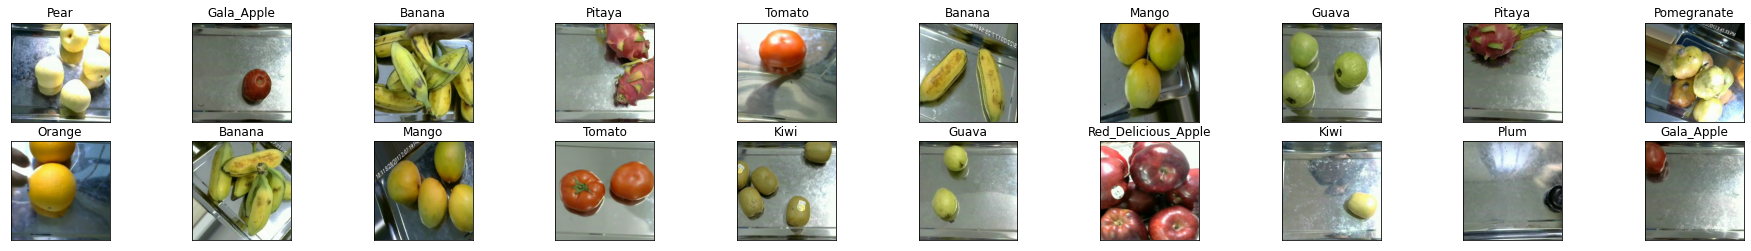

In [10]:
# View 20 random, post processed, training images
fig = plt.figure(figsize=(32, 4)) 
train_loader = torch.utils.data.DataLoader(train_data, batch_size=1, shuffle=True)

n=1
for data in iter(train_loader):
  img,label = data
  if n <= 20:
    image = img.numpy()
    ax = fig.add_subplot(2, 20/2, n, xticks=[], yticks=[])
    plt.imshow(np.transpose(image[0], (1, 2, 0)))
    ax.set_title(classes[label])
    n = n+1

# Model Building, Training, and Testing

## Model Building - Data Augmentation, AlexNet, Helper Functions

In [11]:
alexnet = torchvision.models.alexnet(pretrained=True)

Downloading: "https://download.pytorch.org/models/alexnet-owt-4df8aa71.pth" to /root/.cache/torch/hub/checkpoints/alexnet-owt-4df8aa71.pth


In [12]:
import random
def data_augmentation(img):
  '''
  Perform one of the following data augmentation techniques on the image
  Input img is expected to be a tensor
  Output is also a tensor
  '''
  aug_img = img
  #random.seed(1000)
  val = random.randint(0,5)
  if val is 0:
    aug_img = transforms.functional.gaussian_blur(img=img, kernel_size=13)
  elif val is 1:
    aug_img = transforms.functional.adjust_contrast(img=img, contrast_factor=0.55)
  elif val is 2:
    aug_img = transforms.functional.adjust_contrast(img=img, contrast_factor=1.55)
  elif val is 3:
    aug_img = transforms.functional.adjust_brightness(img=img, brightness_factor=0.45)
  elif val is 4:
    aug_img = transforms.functional.adjust_brightness(img=img, brightness_factor=1.66)
  elif val is 5:
    aug_img = transforms.functional.adjust_saturation(img=img, saturation_factor=0.55)
  #else return same image
  return aug_img

In [13]:
def get_alexnet_features(path, output_path, group, classes, data_aug=True, verify=False):
  '''
  path is where the images are
  output_path is where to store them
  group is [train, val, test]
  verify will show some sample output of images
  '''
  start_time = time.time()
  # ensure output path exists
  if os.path.exists(output_path) is False:
    os.mkdir(output_path)

  data_CC_transform = transforms.Compose([transforms.CenterCrop([224,224]), transforms.ToTensor()])

  dataset = datasets.ImageFolder(os.path.join(path, group), transform=data_CC_transform)

  # load data with batch size of 1 since each image needs to be saved 1 at a time
  batch_size = 1
  num_workers = 1
  loader = torch.utils.data.DataLoader(dataset, batch_size=batch_size,
                                      num_workers=num_workers, shuffle=True)

  feature_path = os.path.join(output_path, group)
  print("Features saved to {}.".format(feature_path))
  if os.path.exists(feature_path):
    # may contain old data
    shutil.rmtree(feature_path)
    print("Found {} removed.".format(feature_path))
  os.mkdir(feature_path)

  n = 0
  fig = plt.figure(figsize=(32, 4)) #for verify later on
  print("Saving data features...")
  for img, label in loader: 
    features = alexnet.features(img)
    features_tensor = torch.from_numpy(features.detach().numpy())

    folder_name = os.path.join(feature_path, str(classes[label]))
    if os.path.isdir(folder_name) is False:
      os.mkdir(folder_name)

    torch.save(features_tensor.squeeze(0), folder_name + '/' + str(n) + '.tensor')
    n += 1

    if data_aug is True:
      aug_img = data_augmentation(img)
      aug_features = alexnet.features(aug_img)
      aug_features_tensor = torch.from_numpy(aug_features.detach().numpy())
      torch.save(aug_features_tensor.squeeze(0), folder_name + '/' + str(n) + '.tensor')
      n += 1

    if verify is True and n <= 20:
      # verification step
      image = img.numpy() #convert to numpy for display
      ax = fig.add_subplot(2, 20/2, n, xticks=[], yticks=[])
      plt.imshow(np.transpose(image[0], (1, 2, 0)))
      ax.set_title(classes[label[0]])

      # for augmented image
      if data_aug is True:
        aug_image = aug_img.numpy()
        ax = fig.add_subplot(2, 20/2, n-1, xticks=[], yticks=[])
        plt.imshow(np.transpose(aug_image[0], (1, 2, 0)))
        ax.set_title(classes[label[0]])

  end_time = time.time()
  print("Total time:  % 6.2f s" % ( end_time-start_time))
  return

In [ ]:
feature_dir = "/root/datasets/V3_combined_all_DS_features"
get_alexnet_features(parent_dir, output_path=feature_dir, group="train", classes=classes, data_aug=True, verify=True)

Features saved to /root/datasets/V3_combined_all_DS_features/train.
Saving data features...


In [ ]:
get_alexnet_features(parent_dir, output_path=feature_dir, group="val", classes=classes, data_aug=False, verify=True)
get_alexnet_features(parent_dir, output_path=feature_dir, group="test", classes=classes, data_aug=False, verify=True)

In [ ]:
def get_data_loader(path, batch_size=32, verify=True):
    '''
    Loads saved tensor files with features extracted using AlexNet
    '''
    # load tensor files from folder
    train_dataset = torchvision.datasets.DatasetFolder(path + '/train', loader=torch.load, extensions=('.tensor'))
    val_dataset = torchvision.datasets.DatasetFolder(path + '/val', loader=torch.load, extensions=('.tensor'))
    test_dataset = torchvision.datasets.DatasetFolder(path + '/test', loader=torch.load, extensions=('.tensor'))

    # Prepare Dataloader
    num_workers = 1
    train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size,
                                             num_workers=num_workers, shuffle=True)
    val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=batch_size,
                                             num_workers=num_workers, shuffle=True)
    test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size,
                                             num_workers=num_workers, shuffle=True)

    # Verification Step - obtain one batch of features
    if verify is True:
      data_iter = iter(train_loader)
      features, labels = data_iter.next()
      print("Training Shape:")
      print(features.shape)
      print(labels.shape)

    return train_loader, val_loader, test_loader

In [ ]:
torch.manual_seed(1) # set the random seed

class AlexNetCNNClassifier(nn.Module):
    def __init__(self):
        super(AlexNetCNNClassifier, self).__init__()
        self.name = "AlexNetCNNClassifier"
        self.conv1 = nn.Conv2d(256, 128, 3) # creates 4x4 feature map
        self.pool = nn.MaxPool2d(2, 2) # createst 2x2 feature map
        self.fc1 = nn.Linear(128*2*2, 19) 

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = x.view(-1, 128*2*2)
        x = self.fc1(x)
        return x

## Model Training

In [ ]:
def train(model, train_loader, val_loader, batch_size=128, num_epochs=64, learn_rate = 0.001):

    torch.manual_seed(1000)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=learn_rate)
    
    train_acc, val_acc, epochs, train_loss_list, val_loss_list = [], [], [], [], []

    # training
    print ("Training Started...")
    start_time = time.time()
    n = 0 # the number of iterations
    epoch_num = 0
    for epoch in range(num_epochs):
        for imgs, labels in iter(train_loader):
            out = model(imgs)             # forward pass
            train_loss = criterion(out, labels) # compute the total train_loss
            train_loss.backward()               # backward pass (compute parameter updates)
            optimizer.step()              # make the updates for each parameter
            optimizer.zero_grad()         # a clean up step for PyTorch
            n += 1

        for imgs, labels in iter(train_loader):
            out = model(imgs)             # forward pass
            val_loss = criterion(out, labels) # compute the total train_loss

        # track the accuracy
        epoch_num += 1
        epochs.append(epoch_num)
        average_train_loss = float(train_loss)
        train_loss_list.append(average_train_loss)
        average_val_loss = float(val_loss)
        val_loss_list.append(average_val_loss) 
        train_acc.append(get_accuracy(model, train_loader))
        val_acc.append(get_accuracy(model, val_loader))
        print("Epoch: {}, Training Accuracy: {:.2f}%, Training Loss: {:.2f}, Validation Accuracy: {:.2f}%, Validation Loss: {:.2f}".format(epoch, train_acc[-1]*100, train_loss_list [-1], val_acc[-1]*100, val_loss_list[-1]))
    # checkpointing
    path = "model_{0}_bs{1}_lr{2}_epoch{3}".format(model.name,batch_size,learn_rate,epoch)
    torch.save(model.state_dict(), path)
    
    # plots
    plt.title("Loss Curve")
    plt.plot(epochs, train_loss_list, label="Train")
    plt.plot(epochs, val_loss_list, label="Validation")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend(loc='best')
    plt.show()

    plt.title("Learning Curve")
    plt.plot(epochs, train_acc, label="Train")
    plt.plot(epochs, val_acc, label="Validation")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.legend(loc='best')
    plt.show()

    end_time = time.time()
    print("Training took {:.2f} seconds".format(end_time - start_time))
    print("Final training accuracy: {:.2f}%".format(train_acc[-1]*100))
    print("Final validation accuracy: {:.2f}%".format(val_acc[-1]*100))

In [ ]:
def get_accuracy(model, data_loader):
    correct = 0
    total = 0
    if (len(data_loader)==0):
      return
    for imgs, labels in data_loader:

        output = model(imgs)
        #select index with maximum prediction score
        pred = output.max(1, keepdim=True)[1]
        correct += pred.eq(labels.view_as(pred)).sum().item()
        total += imgs.shape[0]
    return correct / total

In [ ]:
# Optimal model: Training with 10 epochs, learning rate of 0.001, batch size = 64
train_feature_loader, val_features_loader, test_feature_loader = get_data_loader(feature_dir, batch_size=64, verify=True)
SupermarketAI_model = AlexNetCNNClassifier()
train(SupermarketAI_model, train_feature_loader, val_features_loader, num_epochs=10, learn_rate=0.001, batch_size=64)

## Model Testing

In [ ]:
test_accuracy = get_accuracy(SupermarketAI_model, test_feature_loader)
print("The model generalization accuracy on never before seen test data is: {:.2f}%".format(test_accuracy*100))

# Verification of Model Quantitative Results 

In [ ]:
# Visualize some of the predicted data
fig = plt.figure(figsize=(32, 4))
path = "/root/datasets/V3_combined_all_DS"
val_verif_loader = torch.utils.data.DataLoader(val_data, batch_size=1,num_workers=1, shuffle=True)
n=1

for imgs, labels in iter(val_verif_loader):
    if n <= 20:
        # verification step
        image = imgs.numpy() #convert to numpy for display
        ax = fig.add_subplot(2, 20/2, n, xticks=[], yticks=[])
        out = SupermarketAI_model(alexnet.features(imgs))
        pred = out.max(1, keepdim=True)[1]
        ax.set_title("{} = {}".format(classes[pred[0]], classes[pred[0]] == classes[labels]))
        n = n+1
    else:
        break

In [ ]:
fig = plt.figure(figsize=(32, 4)) 
start = time.time()
n = 1
pred_list = []
actual_labels = []
for imgs, labels in iter(val_verif_loader):
  out = SupermarketAI_model(alexnet.features(imgs))
  pred = out.max(1, keepdim=True)[1]
  pred_list.append(classes[pred[0]])
  actual_labels.append(classes[labels])

end = time.time()
duration = end - start
print(duration)
confusion_matrix(actual_labels, pred_list)

In [ ]:
def plot_confusion_matrix(cm, classes, normalize=False, title='Confusion matrix', cmap=plt.cm.Blues):
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt), horizontalalignment="center", color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

cm = confusion_matrix(actual_labels, pred_list)
plt.figure(figsize=(14,14))
plot_confusion_matrix(cm, classes)

# Faster R-CNN

In [ ]:
#https://www.learnopencv.com/faster-r-cnn-object-detection-with-pytorch/
import torchvision
fasterrcnn_model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)
fasterrcnn_model.eval()

In [ ]:
def get_bb_prediction(img_path, threshold):
    img = Image.open(img_path).convert('RGB') # Load the image
    transform = T.Compose([T.ToTensor()]) # Defing PyTorch Transform
    img = transform(img) # Apply the transform to the image
    pred = fasterrcnn_model([img]) # Pass the image to the fasterrcnn model
    pred_boxes = [[(i[0], i[1]), (i[2], i[3])] for i in list(pred[0]['boxes'].detach().numpy())] # Bounding boxes
    pred_score = list(pred[0]['scores'].detach().numpy())
    pred_t = -1
    for x in pred_score:
        if (x > threshold):
            pred_t = pred_score.index(x)       
    pred_boxes = pred_boxes[:pred_t+1]
    return pred_boxes

In [ ]:
def fast_fruit_bounding_box(img_path, model, classes, threshold=0.5, rect_th=2, text_size=0.5, text_th=2, txt_R=255, txt_G=255, txt_B=255):
  boxes = get_bb_prediction(img_path, threshold) # Get predictions, took out 'pred_cls' after boxes
  img = cv2.imread(img_path) # Read image with cv2
  img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB) # Convert to RGB
  
  transform = T.Compose([T.ToTensor()])
  img_tensor = transform(img)

  fruits_in_img = {}
  for cat in classes:
      fruits_in_img[cat] = 0

  for i in range(len(boxes)):
    cv2.rectangle(img, boxes[i][0], boxes[i][1],color=(0, 255, 0), thickness=rect_th) # Draw Rectangle with the coordinates
    top_left_y = int(boxes[i][0][1])
    top_left_x = int(boxes[i][0][0])
    height = int(abs(boxes[i][1][1] - boxes[i][0][1]))
    width = int(abs(boxes[i][1][0] - boxes[i][0][0]))
    img_cropped = T.functional.resized_crop(img_tensor, top_left_y, top_left_x, height, width, [224,224])
    img_cropped = img_cropped.unsqueeze(0)
    features = alexnet.features(img_cropped)
    out = model(features)
    pred_class = out.max(1, keepdim=True)[1]
    fruits_in_img[classes[pred_class[0]]] += 1
    cv2.putText(img,classes[pred_class[0]], boxes[i][0], cv2.FONT_HERSHEY_SIMPLEX, text_size, (txt_R,txt_G,txt_B),thickness=text_th) # Write the prediction class
  
  plt.figure(figsize=(10,15)) # display the output image
  plt.imshow(img)
  plt.xticks([])
  plt.yticks([])
  plt.show()

  if (len(boxes) == 0):
      print("I detect no fruits in this picture :(")
      return

  for fruit, number in fruits_in_img.items():
      if (number > 1):
          print("There are {} {}s in this image".format(number, fruit))
      elif (number == 1):
          print("There is {} {} in this image".format(number, fruit))

In [ ]:
img_path = "/root/datasets/V3_combined_all_DS/train/Gala_Apple/Gala Apple 00501 3.png"

fast_fruit_bounding_box(img_path, SupermarketAI_model, classes=classes, threshold=0.8)

# Supermarket AI accuracy and results

In [ ]:
'''
Modifying the ImageFolder class to store PIL 
Image path information as well as the image and its label.
'''
import torch
from torchvision import datasets

class ImageFolderWithPaths(datasets.ImageFolder):
    """Custom dataset that includes image file paths. Extends
    torchvision.datasets.ImageFolder
    """

    # override the __getitem__ method. this is the method that dataloader calls
    def __getitem__(self, index):
        # this is what ImageFolder normally returns 
        original_tuple = super(ImageFolderWithPaths, self).__getitem__(index)
        # the image file path
        path = self.imgs[index][0]
        # make a new tuple that includes original and the path
        tuple_with_path = (original_tuple + (path,))
        return tuple_with_path

In [ ]:
def get_data_loader_with_paths(train_dir, val_dir, test_dir, batch_size=1):
    data_CC_transform = transforms.Compose([transforms.CenterCrop([224,224]), transforms.ToTensor()])

    train_dataset_with_paths = ImageFolderWithPaths(train_dir, transform=data_CC_transform)
    train_loader_with_paths = torch.utils.data.DataLoader(train_dataset_with_paths, batch_size=batch_size, shuffle=True)

    val_dataset_with_paths = ImageFolderWithPaths(val_dir, transform=data_CC_transform)
    val_loader_with_paths = torch.utils.data.DataLoader(val_dataset_with_paths, batch_size=batch_size, shuffle=True)

    test_dataset_with_paths = ImageFolderWithPaths(test_dir, transform=data_CC_transform)
    test_loader_with_paths = torch.utils.data.DataLoader(test_dataset_with_paths, batch_size=batch_size, shuffle=True)

    return train_loader_with_paths, val_loader_with_paths, test_loader_with_paths

In [ ]:
def get_acc_data(data_dir, batch_size=1, num_images=200, group="acc"):
    # create acc directory and copy 200 images of each class into it
    acc_dir = os.path.join("/root/datasets/V3_combined_all_DS", group)
    if os.path.exists(acc_dir) == False:
        os.mkdir(acc_dir)
    os.chdir(data_dir)
    category_list = list(filter(lambda x: os.path.isdir(x), os.listdir()))
    for category in category_list:
        n =  1
        cat_source_dir = os.path.join(data_dir,category)
        cat_dest_dir = os.path.join(acc_dir, category)
        if os.path.exists(cat_dest_dir) == False:
            os.mkdir(cat_dest_dir)
        files = glob(os.path.join(cat_source_dir,"*.png"))
        for file_ in files:
            if (n > num_images):
                break
            cat_source_file = os.path.join(cat_source_dir, file_)
            cat_dest_file = cat_dest_dir + '/' + file_.split('/')[-1]
            shutil.copyfile(cat_source_file, cat_dest_file)
            n += 1
    return

In [ ]:
def get_data_loader_wpaths(data_dir, batch_size=1, shuffle=True):
    data_CC_transform = transforms.Compose([transforms.CenterCrop([224,224]), transforms.ToTensor()])

    dataset_with_paths = ImageFolderWithPaths(data_dir, transform=data_CC_transform)
    loader_with_paths = torch.utils.data.DataLoader(dataset_with_paths, batch_size=batch_size, shuffle=shuffle)

    return loader_with_paths

In [ ]:
def get_feature_loader(path, group, batch_size=32, verify=True):
    '''
    Loads saved tensor files with features extracted using AlexNet
    '''
    # load tensor files from folder
    dataset = torchvision.datasets.DatasetFolder(os.path.join(path, group), loader=torch.load, extensions=('.tensor'))
    # Prepare Dataloader
    num_workers = 1
    loader = torch.utils.data.DataLoader(dataset, batch_size=batch_size,
                                         num_workers=num_workers, shuffle=True)

    # Verification Step - obtain one batch of features
    if verify is True:
      data_iter = iter(loader)
      features, labels = data_iter.next()
      print("Data Shape:")
      print(features.shape)
      print(labels.shape)

    return loader

In [ ]:
def get_supermarket_AI_accuracy(model, data_loader, threshold=0.8):
    correct = 0
    total = 0

    if (len(data_loader) == 0):
        return

    for img, label, path in data_loader:
        img_boxes = get_bb_prediction(path[0], threshold)
        img_plt = cv2.imread(path[0])
        for i in range(len(img_boxes)):
            cv2.rectangle(img_plt, img_boxes[i][0], img_boxes[i][1],color=(0, 255, 0), thickness=2)
            top_left_y = int(img_boxes[i][0][1])
            top_left_x = int(img_boxes[i][0][0])
            height = int(abs(img_boxes[i][1][1] - img_boxes[i][0][1]))
            width = int(abs(img_boxes[i][1][0] - img_boxes[i][0][0]))
            img_PIL = Image.fromarray(img_plt)
            img_cropped = T.functional.resized_crop(img_PIL, top_left_y, top_left_x, height, width, [224,224])
            transform = T.Compose([T.ToTensor()])
            img_cropped_tensor = transform(img_cropped)
            img_cropped_tensor = img_cropped_tensor.unsqueeze(0)
            features = alexnet.features(img_cropped_tensor)
            out = model(features)
            pred_class = out.max(1, keepdim=True)[1]
            correct += pred_class.eq(label.view_as(pred_class)).sum().item()
            print(total)
            total += img.shape[0]
    
    return correct / total

In [ ]:
def get_alexnet_features_bb_imp(path, output_path, src_group, dest_grp, classes, data_aug=False, verify=False, threshold=0.8):
  '''
  getting alexnet features using bounding box implementation
  path is where the images are, DATASET MUST HAVE PATH INFORMATION FOR EACH IMAGE
  output_path is where to store them
  group is [train, val, test]
  verify will show some sample output of images
  '''
  start_time = time.time()
  # ensure output path exists
  if os.path.exists(output_path) is False:
    os.mkdir(output_path)


  loader = get_data_loader_wpaths(os.path.join(path, src_group), batch_size=1, shuffle=False)

  feature_path = os.path.join(output_path, dest_grp)
  print("Features saved to {}.".format(feature_path))
  if os.path.exists(feature_path):
    # may contain old data
    shutil.rmtree(feature_path)
    print("Found {} removed.".format(feature_path))
  os.mkdir(feature_path)

  fig = plt.figure(figsize=(32, 4)) #for verify later on
  n = 0
  cant_detect = 0
  print("Saving data features...")
  for img, label, path in loader:
    img_boxes = get_bb_prediction(path[0], threshold)
    img_plt = cv2.imread(path[0])

    if (len(img_boxes) == 0):
      cant_detect += 1

    for i in range(len(img_boxes)):
      cv2.rectangle(img_plt, img_boxes[i][0], img_boxes[i][1],color=(0, 255, 0), thickness=2)
      top_left_y = int(img_boxes[i][0][1])
      top_left_x = int(img_boxes[i][0][0])
      height = int(abs(img_boxes[i][1][1] - img_boxes[i][0][1]))
      width = int(abs(img_boxes[i][1][0] - img_boxes[i][0][0]))
      img_PIL = Image.fromarray(img_plt)
      img_cropped = T.functional.resized_crop(img_PIL, top_left_y, top_left_x, height, width, [224,224])
      transform = T.Compose([T.ToTensor()])
      img_cropped_tensor = transform(img_cropped)
      img_cropped_tensor = img_cropped_tensor.unsqueeze(0)
      features = alexnet.features(img_cropped_tensor)
      features_tensor = torch.from_numpy(features.detach().numpy())

      folder_name = os.path.join(feature_path, str(classes[label]))
      if os.path.isdir(folder_name) is False:
        os.mkdir(folder_name)

      torch.save(features_tensor.squeeze(0), folder_name + '/' + str(n) + '.tensor')
      n += 1

      if data_aug is True:
        aug_img = data_augmentation(img_cropped_tensor)
        aug_features = alexnet.features(aug_img)
        aug_features_tensor = torch.from_numpy(aug_features.detach().numpy())
        torch.save(aug_features_tensor.squeeze(0), folder_name + '/' + str(n) + '.tensor')
        n += 1

      if verify is True and n <= 20:
        # verification step
        image = img_cropped_tensor.numpy() #convert to numpy for display
        ax = fig.add_subplot(2, 20/2, n, xticks=[], yticks=[])
        plt.imshow(np.transpose(image[0], (1, 2, 0)))
        ax.set_title(classes[label[0]])

        # for augmented image
        if data_aug is True:
          aug_image = aug_img.numpy()
          ax = fig.add_subplot(2, 20/2, n-1, xticks=[], yticks=[])
          plt.imshow(np.transpose(aug_image[0], (1, 2, 0)))
          ax.set_title(classes[label[0]])

  end_time = time.time()
  print("Total time:  % 6.2f s" % ( end_time-start_time))
  return cant_detect

In [ ]:
def get_accuracy_v2(model, data_loader, total=0):
    correct = 0
    if (len(data_loader)==0):
      return
    for imgs, labels in data_loader:
        output = model(imgs)
        #select index with maximum prediction score
        pred = output.max(1, keepdim=True)[1]
        correct += pred.eq(labels.view_as(pred)).sum().item()
        total += imgs.shape[0]
    return correct / total

In [ ]:
! rm -rf "/root/datasets/V3_combined_all_DS/acc"
! rm -rf "/root/datasets/V3_combined_all_DS_features/acc_bb"
test_dir = "/root/datasets/V3_combined_all_DS/test"
src_group = "acc"
dest_grp = "acc_bb"

get_acc_data(test_dir, batch_size=1, num_images=100, group=src_group)
path = "/root/datasets/V3_combined_all_DS"
acc_features_dir = "/root/datasets/V3_combined_all_DS_features"
cant_detect = get_alexnet_features_bb_imp(path, acc_features_dir, src_group, dest_grp, classes, data_aug=False, verify=False, threshold=0.8)

In [ ]:
group = "acc_bb"
acc_bb_feature_loader = get_feature_loader(acc_features_dir, group, batch_size=1, verify=True)
fast_fruit_bb_acc = get_accuracy_v2(SupermarketAI_model, acc_bb_feature_loader, total=cant_detect)

print("Supermarket AI accuracy on a subset of the Testing data, with bounding box implementation is: {:.2f}%".format(fast_fruit_bb_acc*100))

! rm -rf "/root/datasets/V3_combined_all_DS_features/acc"
group = "acc"
get_alexnet_features(path, acc_features_dir, group, classes, data_aug=False, verify=False)
acc_feature_loader = get_feature_loader(acc_features_dir, group, batch_size=1, verify=True)
fast_fruit_acc = get_accuracy(SupermarketAI_model, acc_feature_loader)

print("Supermarket AI accuracy on a subset of the Testing data, WITHOUT bounding box implementation is: {:.2f}%".format(fast_fruit_acc*100))

In [ ]:
# Testing when we do data augmentation on test data
! rm -rf "/root/datasets/V3_combined_all_DS_features/acc"
group = "acc"
get_alexnet_features(path, acc_features_dir, group, classes, data_aug=True, verify=False)
acc_dataaug_feature_loader = get_feature_loader(acc_features_dir, group, batch_size=1, verify=True)
fast_fruit_acc = get_accuracy(SupermarketAI_model, acc_dataaug_feature_loader)

print("Supermarket AI accuracy on a subset of the Testing data, WITHOUT bounding box implementation, with data augmentation is: {:.2f}%".format(fast_fruit_acc*100))

In [ ]:
# Confusion matrix for bb
fig = plt.figure(figsize=(32, 4)) 
start = time.time()
n = 1
pred_list = []
actual_labels = []
for imgs, labels in iter(acc_bb_feature_loader):
  out = SupermarketAI_model(imgs)
  pred = out.max(1, keepdim=True)[1]
  pred_list.append(classes[pred[0]])
  actual_labels.append(classes[labels])

cm = confusion_matrix(actual_labels, pred_list)
plt.figure(figsize=(14,14))
plot_confusion_matrix(cm, classes)
end = time.time()
duration = end - start
print("Plotting the confusion matrix for bounding box implementation took: {}".format(duration))

In [ ]:
# Confusion matrix for classification without data_aug
fig = plt.figure(figsize=(32, 4)) 
start = time.time()
n = 1
pred_list = []
actual_labels = []
for imgs, labels in iter(acc_feature_loader):
  out = SupermarketAI_model(imgs)
  pred = out.max(1, keepdim=True)[1]
  pred_list.append(classes[pred[0]])
  actual_labels.append(classes[labels])

cm = confusion_matrix(actual_labels, pred_list)
plt.figure(figsize=(14,14))
plot_confusion_matrix(cm, classes)
end = time.time()
duration = end - start
print("Plotting the confusion matrix for bounding box implementation took: {}".format(duration))

# Fast Fruit Demonstration Helper Functions

In [ ]:
def fast_fruit_classification(img_path, model, classes):
  img = Image.open(img_path).convert('RGB')
  data_CC_transform = transforms.Compose([transforms.CenterCrop([224,224]), transforms.ToTensor()])
  img_tensor = data_CC_transform(img)
  img_tensor = img_tensor.unsqueeze(0)
  features = alexnet.features(img_tensor)
  out = model(features)
  pred_class = out.max(1, keepdim=True)[1]
  fruit = classes[pred_class[0]]
  plt.figure(figsize=(10,15)) # display the output image
  plt.imshow(img)
  plt.xticks([])
  plt.yticks([])
  plt.show()
  print("This image contains one or more {}s".format(fruit))

In [ ]:
def fast_fruit_demo(img_path, model, classes=classes, threshold=0.5, rect_th=2, text_size=0.5, text_th=2, txt_R=255, txt_G=255, txt_B=255):
  plt.figure(figsize=(30,10))
  ## Classification Demo
  img = Image.open(img_path).convert('RGB')
  data_CC_transform = transforms.Compose([transforms.CenterCrop([224,224]), transforms.ToTensor()])
  img_tensor = data_CC_transform(img)
  img_tensor = img_tensor.unsqueeze(0)
  features = alexnet.features(img_tensor)
  out = model(features)
  pred_class = out.max(1, keepdim=True)[1]
  fruit = classes[pred_class[0]]
  # Plot the image
  plt.subplot(1, 2, 1)
  plt.imshow(img)
  plt.title("This image contains one or more {}s".format(fruit), fontweight="bold", size=20)
   
  ## Bounding Box Demo
  boxes = get_bb_prediction(img_path, threshold) # Get predictions, took out 'pred_cls' after boxes
  img = cv2.imread(img_path) # Read image with cv2
  img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB) # Convert to RGB
  
  transform = T.Compose([T.ToTensor()])
  img_tensor = transform(img)

  fruits_in_img = {}
  for cat in classes:
      fruits_in_img[cat] = 0

  for i in range(len(boxes)):
    cv2.rectangle(img, boxes[i][0], boxes[i][1],color=(0, 255, 0), thickness=rect_th) # Draw Rectangle with the coordinates
    top_left_y = int(boxes[i][0][1])
    top_left_x = int(boxes[i][0][0])
    height = int(abs(boxes[i][1][1] - boxes[i][0][1]))
    width = int(abs(boxes[i][1][0] - boxes[i][0][0]))
    img_cropped = T.functional.resized_crop(img_tensor, top_left_y, top_left_x, height, width, [224,224])
    img_cropped = img_cropped.unsqueeze(0)
    features = alexnet.features(img_cropped)
    out = model(features)
    pred_class = out.max(1, keepdim=True)[1]
    fruits_in_img[classes[pred_class[0]]] += 1
    cv2.putText(img,classes[pred_class[0]], boxes[i][0], cv2.FONT_HERSHEY_SIMPLEX, text_size, (txt_R,txt_G,txt_B),thickness=text_th) # Write the prediction class
  
  plt.subplot(1, 2, 2)
  plt.imshow(img)

  if (len(boxes) == 0):
    plt.title("I detect no fruits in this picture :(", fontweight="bold", size=20)
    plt.tight_layout()
    plt.show()
    return

  title = ""
  for fruit, number in fruits_in_img.items():
    if (number > 1):
      title = title + "\n" + "There are {} {}s in this image".format(number, fruit)
    elif (number == 1):
       title = title + "\n" + "There is {} {} in this image".format(number, fruit)
  plt.title(title, fontweight="bold", size=20)
  plt.tight_layout()
  plt.show()

# Fast Fruit Demonstration

In [ ]:
# Copy all of the images onto the host machine
! rm -rf /root/datasets/demo_images
! cp -r '/content/drive/MyDrive/APS360 Project/Dataset Zip Files/demo_images' '/root/datasets/demo_images'

In [ ]:
parent_path = "/root/datasets/demo_images/"
fruit = "Orange.png"
img_path = parent_path + fruit
fast_fruit_demo(img_path, SupermarketAI_model, classes=classes, threshold=0.8, rect_th=2, text_size=0.75, text_th=2, txt_R=255, txt_G=255, txt_B=255)

In [ ]:
parent_path = "/root/datasets/demo_images/"
fruit = "Fuji_Apple.png"
img_path = parent_path + fruit
fast_fruit_demo(img_path, SupermarketAI_model, classes=classes, threshold=0.8, rect_th=2, text_size=0.5, text_th=1, txt_R=255, txt_G=255, txt_B=255)

In [ ]:
parent_path = "/root/datasets/demo_images/"
fruit = "banana_1.png"
img_path = parent_path + fruit
fast_fruit_demo(img_path, SupermarketAI_model, classes=classes, threshold=0.8, rect_th=2, text_size=0.5, text_th=1, txt_R=255, txt_G=255, txt_B=255)

In [ ]:
parent_path = "/root/datasets/demo_images/"
fruit = "8_red_apples.png"
img_path = parent_path + fruit
fast_fruit_demo(img_path, SupermarketAI_model, classes=classes, threshold=0.8, rect_th=2, text_size=1, text_th=3, txt_R=255, txt_G=255, txt_B=255)

In [ ]:
parent_path = "/root/datasets/demo_images/"
fruit = "orange_4.png"
img_path = parent_path + fruit
fast_fruit_demo(img_path, SupermarketAI_model, classes=classes, threshold=0.8, rect_th=1, text_size=0.35, text_th=1, txt_R=255, txt_G=255, txt_B=255)

In [ ]:
parent_path = "/root/datasets/demo_images/"
fruit = "2_apple_1_orange.png"
img_path = parent_path + fruit
fast_fruit_bounding_box(img_path, SupermarketAI_model, classes=classes, threshold=0.8, rect_th=6, text_size=5, text_th=6, txt_R=255, txt_G=255, txt_B=255)

In [ ]:
fruit = "1_Fuji_Apple.png"
parent_path = "/root/datasets/demo_images/"
img_path = parent_path + fruit
fast_fruit_bounding_box(img_path, SupermarketAI_model, classes=classes, threshold=0.8, rect_th=6, text_size=5, text_th=6, txt_R=255, txt_G=255, txt_B=255)

In [ ]:
fruit = "1_orange.png"
parent_path = "/root/datasets/demo_images/"
img_path = parent_path + fruit
fast_fruit_bounding_box(img_path, SupermarketAI_model, classes=classes, threshold=0.8, rect_th=6, text_size=5, text_th=6, txt_R=255, txt_G=255, txt_B=255)

In [ ]:
fruit = "1_pear.png"
parent_path = "/root/datasets/demo_images/"
img_path = parent_path + fruit
fast_fruit_bounding_box(img_path, SupermarketAI_model, classes=classes, threshold=0.8, rect_th=6, text_size=5, text_th=6, txt_R=255, txt_G=255, txt_B=255)

In [ ]:
fruit = "1_pear_2.png"
parent_path = "/root/datasets/demo_images/"
img_path = parent_path + fruit
fast_fruit_bounding_box(img_path, SupermarketAI_model, classes=classes, threshold=0.8, rect_th=6, text_size=5, text_th=6, txt_R=255, txt_G=255, txt_B=255)

In [ ]:
fruit = "1_pommegranate.png"
parent_path = "/root/datasets/demo_images/"
img_path = parent_path + fruit
fast_fruit_bounding_box(img_path, SupermarketAI_model, classes=classes, threshold=0.8, rect_th=6, text_size=5, text_th=6, txt_R=255, txt_G=255, txt_B=255)

In [ ]:
fruit = "1_red_1_green_apple.png"
parent_path = "/root/datasets/demo_images/"
img_path = parent_path + fruit
fast_fruit_bounding_box(img_path, SupermarketAI_model, classes=classes, threshold=0.8, rect_th=6, text_size=5, text_th=6, txt_R=255, txt_G=255, txt_B=255)

In [ ]:
fruit = "1_tomato.png"
parent_path = "/root/datasets/demo_images/"
img_path = parent_path + fruit
fast_fruit_bounding_box(img_path, SupermarketAI_model, classes=classes, threshold=0.8, rect_th=6, text_size=5, text_th=6, txt_R=255, txt_G=255, txt_B=255)

In [ ]:
fruit = "1green_apple_1orange.png"
parent_path = "/root/datasets/demo_images/"
img_path = parent_path + fruit
fast_fruit_bounding_box(img_path, SupermarketAI_model, classes=classes, threshold=0.8, rect_th=6, text_size=5, text_th=6, txt_R=255, txt_G=255, txt_B=255)

In [ ]:
fruit = "2_fuji_apples.png"
parent_path = "/root/datasets/demo_images/"
img_path = parent_path + fruit
fast_fruit_bounding_box(img_path, SupermarketAI_model, classes=classes, threshold=0.8, rect_th=6, text_size=5, text_th=6, txt_R=255, txt_G=255, txt_B=255)

In [ ]:
fruit = "2pome_1pear_1orang_2fjapple_2tomato.png"
parent_path = "/root/datasets/demo_images/"
img_path = parent_path + fruit
fast_fruit_bounding_box(img_path, SupermarketAI_model, classes=classes, threshold=0.8, rect_th=6, text_size=5, text_th=6, txt_R=255, txt_G=255, txt_B=255)

In [ ]:
fruit = "2pome_1pear_1orang_2fjapple.png"
parent_path = "/root/datasets/demo_images/"
img_path = parent_path + fruit
fast_fruit_bounding_box(img_path, SupermarketAI_model, classes=classes, threshold=0.8, rect_th=6, text_size=5, text_th=6, txt_R=255, txt_G=255, txt_B=255)

In [ ]:
fruit = "3_pomegranate.png"
parent_path = "/root/datasets/demo_images/"
img_path = parent_path + fruit
fast_fruit_bounding_box(img_path, SupermarketAI_model, classes=classes, threshold=0.8, rect_th=6, text_size=5, text_th=6, txt_R=255, txt_G=255, txt_B=255)

In [ ]:
fruit = "3_tomatos.png"
parent_path = "/root/datasets/demo_images/"
img_path = parent_path + fruit
fast_fruit_bounding_box(img_path, SupermarketAI_model, classes=classes, threshold=0.8, rect_th=6, text_size=5, text_th=6, txt_R=255, txt_G=255, txt_B=255)

In [ ]:
fruit = "banana_2.png"
parent_path = "/root/datasets/demo_images/"
img_path = parent_path + fruit
fast_fruit_bounding_box(img_path, SupermarketAI_model, classes=classes, threshold=0.8, rect_th=6, text_size=5, text_th=6, txt_R=255, txt_G=255, txt_B=255)

In [ ]:
fruit = "banana_3.png"
parent_path = "/root/datasets/demo_images/"
img_path = parent_path + fruit
fast_fruit_bounding_box(img_path, SupermarketAI_model, classes=classes, threshold=0.8, rect_th=6, text_size=5, text_th=6, txt_R=255, txt_G=255, txt_B=255)

In [ ]:
fruit = "banana_4.png"
parent_path = "/root/datasets/demo_images/"
img_path = parent_path + fruit
fast_fruit_bounding_box(img_path, SupermarketAI_model, classes=classes, threshold=0.8, rect_th=6, text_size=5, text_th=6, txt_R=255, txt_G=255, txt_B=255)

In [ ]:
fruit = "Banana.png"
parent_path = "/root/datasets/demo_images/"
img_path = parent_path + fruit
fast_fruit_bounding_box(img_path, SupermarketAI_model, classes=classes, threshold=0.8, rect_th=6, text_size=5, text_th=6, txt_R=255, txt_G=255, txt_B=255)

In [ ]:
fruit = "Gala_Apple.png"
parent_path = "/root/datasets/demo_images/"
img_path = parent_path + fruit
fast_fruit_bounding_box(img_path, SupermarketAI_model, classes=classes, threshold=0.8, rect_th=6, text_size=5, text_th=6, txt_R=255, txt_G=255, txt_B=255)

In [ ]:
fruit = "Granny_Smith_Applr.png"
parent_path = "/root/datasets/demo_images/"
img_path = parent_path + fruit
fast_fruit_bounding_box(img_path, SupermarketAI_model, classes=classes, threshold=0.8, rect_th=6, text_size=5, text_th=6, txt_R=255, txt_G=255, txt_B=255)

In [ ]:
fruit = "Mandarin_scale.png"
parent_path = "/root/datasets/demo_images/"
img_path = parent_path + fruit
fast_fruit_bounding_box(img_path, SupermarketAI_model, classes=classes, threshold=0.8, rect_th=6, text_size=5, text_th=6, txt_R=255, txt_G=255, txt_B=255)

In [ ]:
fruit = "orange_1.png"
parent_path = "/root/datasets/demo_images/"
img_path = parent_path + fruit
fast_fruit_bounding_box(img_path, SupermarketAI_model, classes=classes, threshold=0.8, rect_th=6, text_size=5, text_th=6, txt_R=255, txt_G=255, txt_B=255)

In [ ]:
fruit = "orange_2.png"
parent_path = "/root/datasets/demo_images/"
img_path = parent_path + fruit
fast_fruit_bounding_box(img_path, SupermarketAI_model, classes=classes, threshold=0.8, rect_th=6, text_size=5, text_th=6, txt_R=255, txt_G=255, txt_B=255)

In [ ]:
fruit = "orange_3.png"
parent_path = "/root/datasets/demo_images/"
img_path = parent_path + fruit
fast_fruit_bounding_box(img_path, SupermarketAI_model, classes=classes, threshold=0.8, rect_th=6, text_size=5, text_th=6, txt_R=255, txt_G=255, txt_B=255)

In [ ]:
fruit = "Orange_bag.png"
parent_path = "/root/datasets/demo_images/"
img_path = parent_path + fruit
fast_fruit_bounding_box(img_path, SupermarketAI_model, classes=classes, threshold=0.8, rect_th=6, text_size=5, text_th=6, txt_R=255, txt_G=255, txt_B=255)

In [ ]:
fruit = "persimmon_1.png"
parent_path = "/root/datasets/demo_images/"
img_path = parent_path + fruit
fast_fruit_bounding_box(img_path, SupermarketAI_model, classes=classes, threshold=0.8, rect_th=6, text_size=5, text_th=6, txt_R=255, txt_G=255, txt_B=255)

In [ ]:
fruit = "persimmon_2.png"
parent_path = "/root/datasets/demo_images/"
img_path = parent_path + fruit
fast_fruit_bounding_box(img_path, SupermarketAI_model, classes=classes, threshold=0.8, rect_th=6, text_size=5, text_th=6, txt_R=255, txt_G=255, txt_B=255)

In [ ]:
fruit = "persimmon_3.png"
parent_path = "/root/datasets/demo_images/"
img_path = parent_path + fruit
fast_fruit_bounding_box(img_path, SupermarketAI_model, classes=classes, threshold=0.8, rect_th=6, text_size=5, text_th=6, txt_R=255, txt_G=255, txt_B=255)

# Fast Fruit Evaluate on New Data - Test set

In [ ]:
src_group = "eval_test_subset"
get_acc_data(test_dir, batch_size=1, num_images=2, group=src_group)
path = os.path.join("/root/datasets/V3_combined_all_DS", src_group)
img_paths = glob(os.path.join(path,"*.png"))
for img_path in img_paths:
    fast_fruit_bounding_box(img_path, SupermarketAI_model, classes=classes, threshold=0.8, rect_th=6, text_size=5, text_th=6, txt_R=255, txt_G=255, txt_B=255)